In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
print(os.getcwd())
drive.mount('/content/drive')

/content
Mounted at /content/drive


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch
import time
from datasets import load_dataset

# mps_device = torch.device("cpu")
mps_device = torch.device("cuda")
cpu = torch.device('cpu')
batch_size = 1000

def load_model(model_path):
    tokenizer_bert = AutoTokenizer.from_pretrained(model_path)
    model_bert = AutoModel.from_pretrained(model_path)
    return model_bert, tokenizer_bert

def encode(sentences, model, tokenizer):
    start = time.time()
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input.to(mps_device))
    final_tensor = model_output.last_hidden_state.mean(dim=1).squeeze()
    print(f"Time taken to encode: {time.time() - start}")
    return final_tensor

def calculate_embeddings(dataset, model, tokenizer):
    embeddings_flattened = []
    print(f"Calculating embeddings for {len(dataset)} samples")
    for i in range(0, len(dataset), batch_size):
        print(f"Processing batch {i} to {i+batch_size}")
        batch = dataset.iloc[i:i+batch_size]
        batch_embedding1 = encode(batch['sentence1'].to_list(), model, tokenizer)
        batch_embedding2 = encode(batch['sentence2'].to_list(), model, tokenizer)
        for emb1, emb2 in zip(batch_embedding1, batch_embedding2):
            embeddings_flattened.append(torch.stack([emb1, emb2]).to(cpu))

    return np.array(embeddings_flattened)

def filter_for_single_pt(df):
    unique_paraphrase_types = set()
    df['paraphrase_types'].apply(lambda x: unique_paraphrase_types.update(x) if isinstance(x, (list, np.ndarray)) else unique_paraphrase_types.add(x))
    unique_paraphrase_types = list(unique_paraphrase_types)
    paraphrase_type_data_dict = {}

    for row in unique_paraphrase_types:
        reduced_to_similar_paraphrase_type = df[df['paraphrase_types']
                        .apply(lambda x: row in x if isinstance(x, (list, np.ndarray)) else row == x)]
        paraphrase_type_data_dict[row] = reduced_to_similar_paraphrase_type

    return paraphrase_type_data_dict

def plot_hist(array_mean, key):
    window_size = 20
    averages = [np.mean(array_mean[i:i + window_size]) for i in range(0, len(array_mean), window_size)]
    indices = list(range(0, len(array_mean), window_size))

    plt.figure(figsize=(25, 10))
    plt.plot(indices, averages, color='blue', marker='o', linestyle='-')
    plt.title('Scatter Plot of Average Values of Array Segments')
    plt.xlabel('Array Index')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.savefig(f'{key}_{window_size}.png', dpi=600)
    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5801 [00:00<?, ? examples/s]

Calculating embeddings for 605 samples
Processing batch 0 to 1000
Time taken to encode: 6.2120795249938965
Time taken to encode: 0.1631162166595459


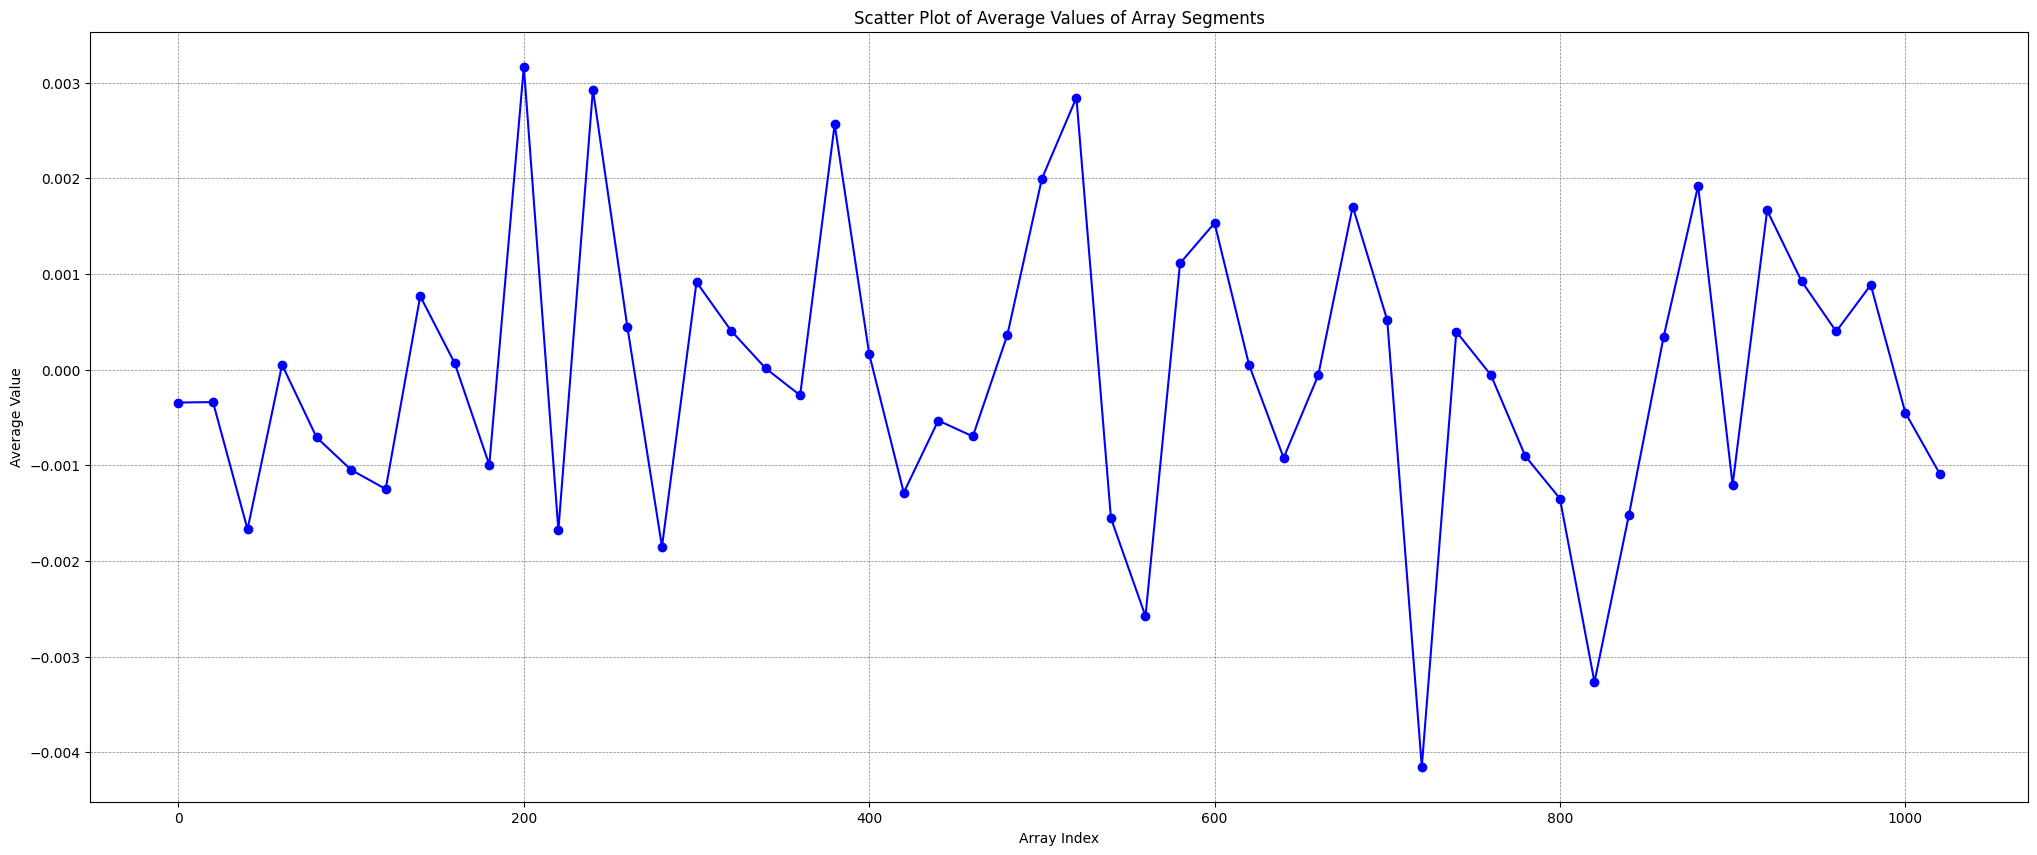

Calculating embeddings for 66 samples
Processing batch 0 to 1000
Time taken to encode: 0.03997445106506348
Time taken to encode: 0.5321094989776611


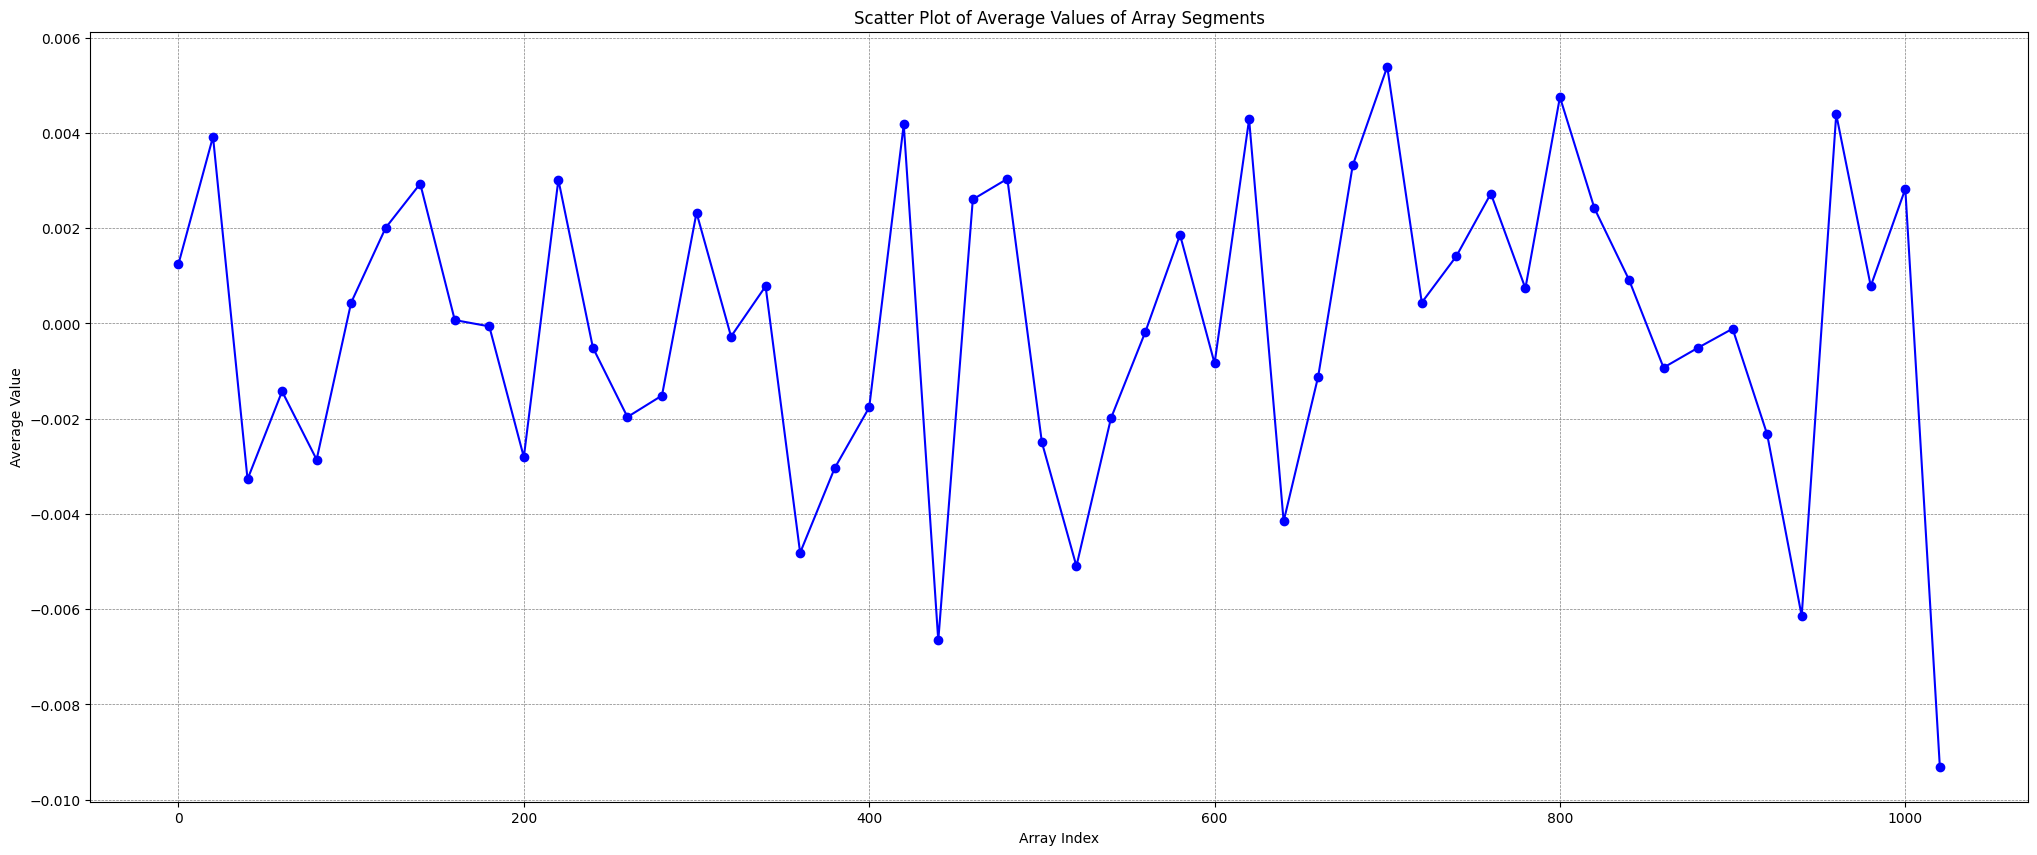

Calculating embeddings for 4 samples
Processing batch 0 to 1000
Time taken to encode: 0.05818510055541992
Time taken to encode: 0.017618894577026367


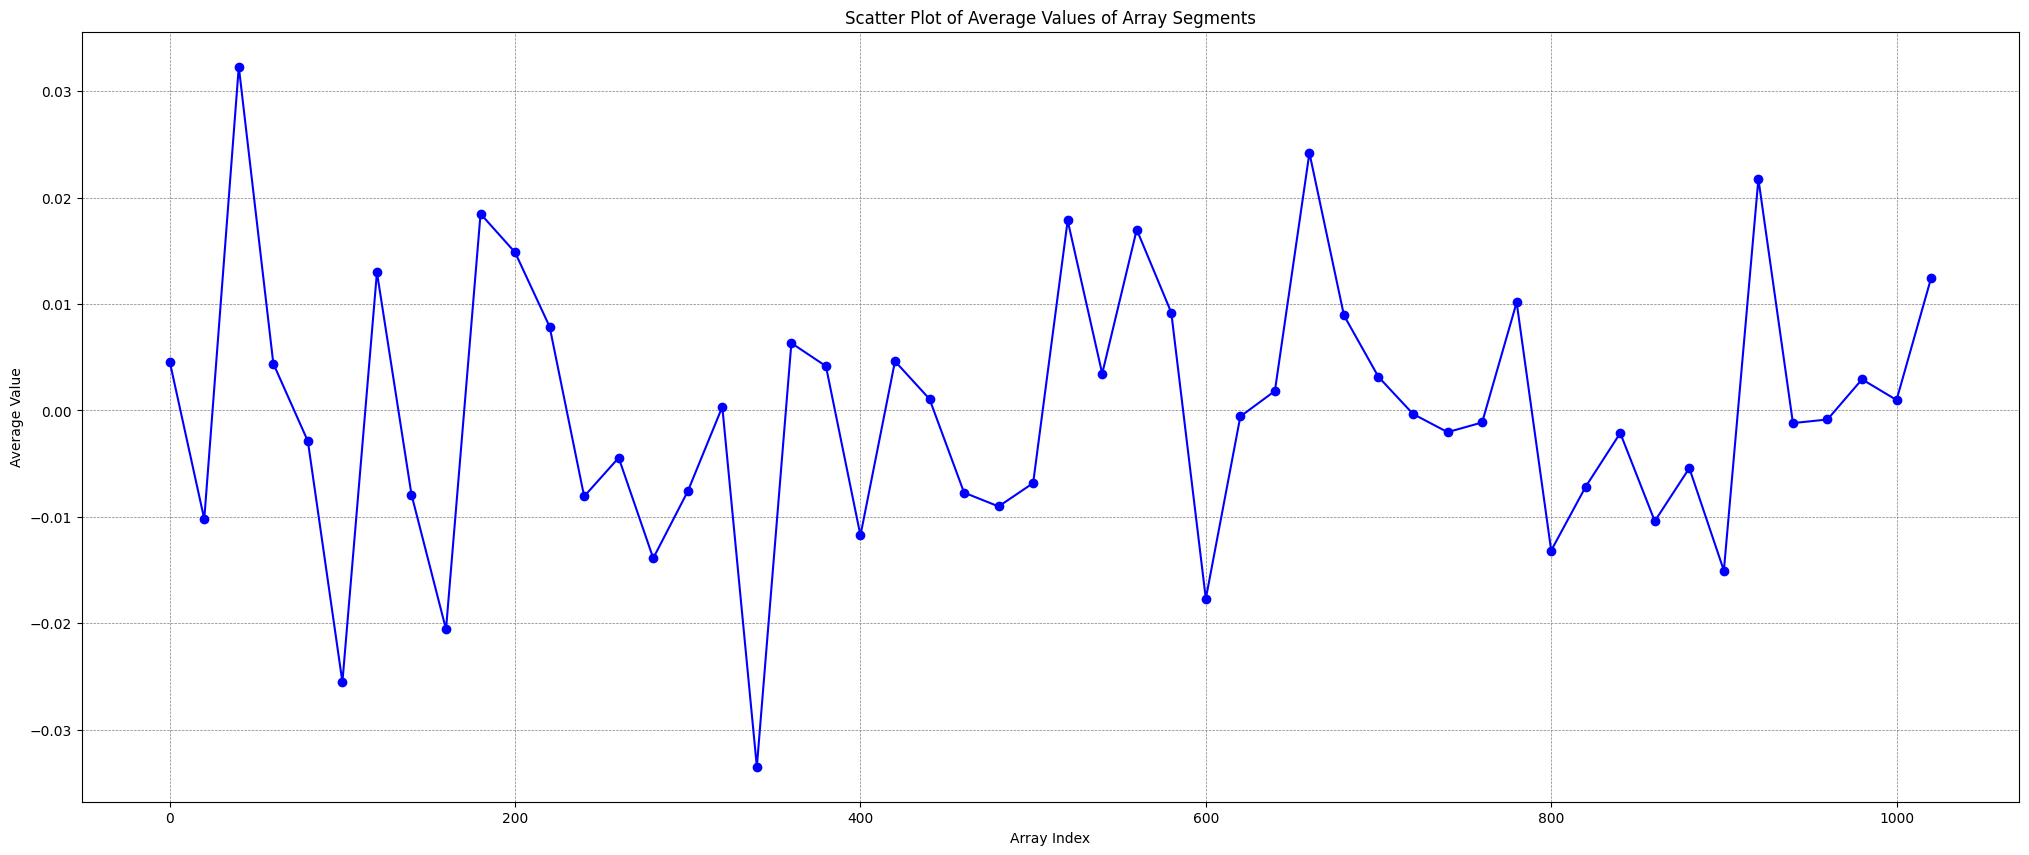

Calculating embeddings for 2988 samples
Processing batch 0 to 1000
Time taken to encode: 0.46926307678222656
Time taken to encode: 8.269628763198853
Processing batch 1000 to 2000
Time taken to encode: 0.23162150382995605
Time taken to encode: 8.38694953918457
Processing batch 2000 to 3000
Time taken to encode: 0.1270756721496582
Time taken to encode: 8.748088121414185


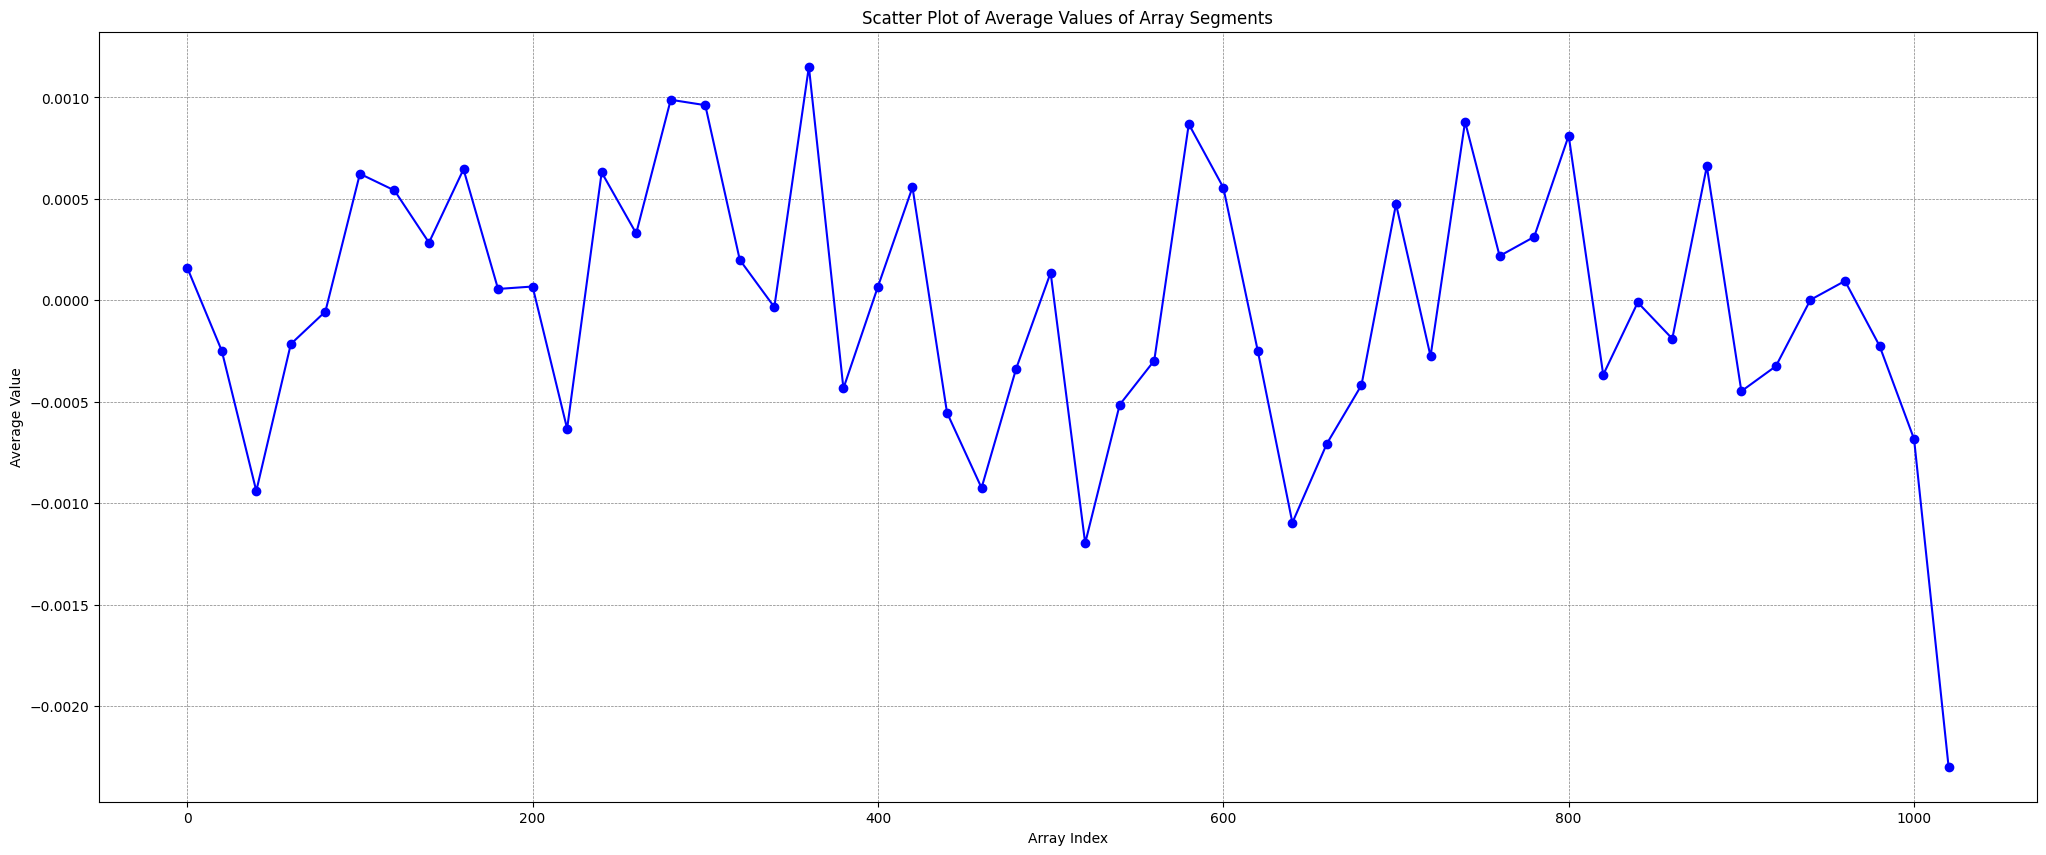

Calculating embeddings for 448 samples
Processing batch 0 to 1000
Time taken to encode: 0.12529754638671875
Time taken to encode: 3.8160288333892822


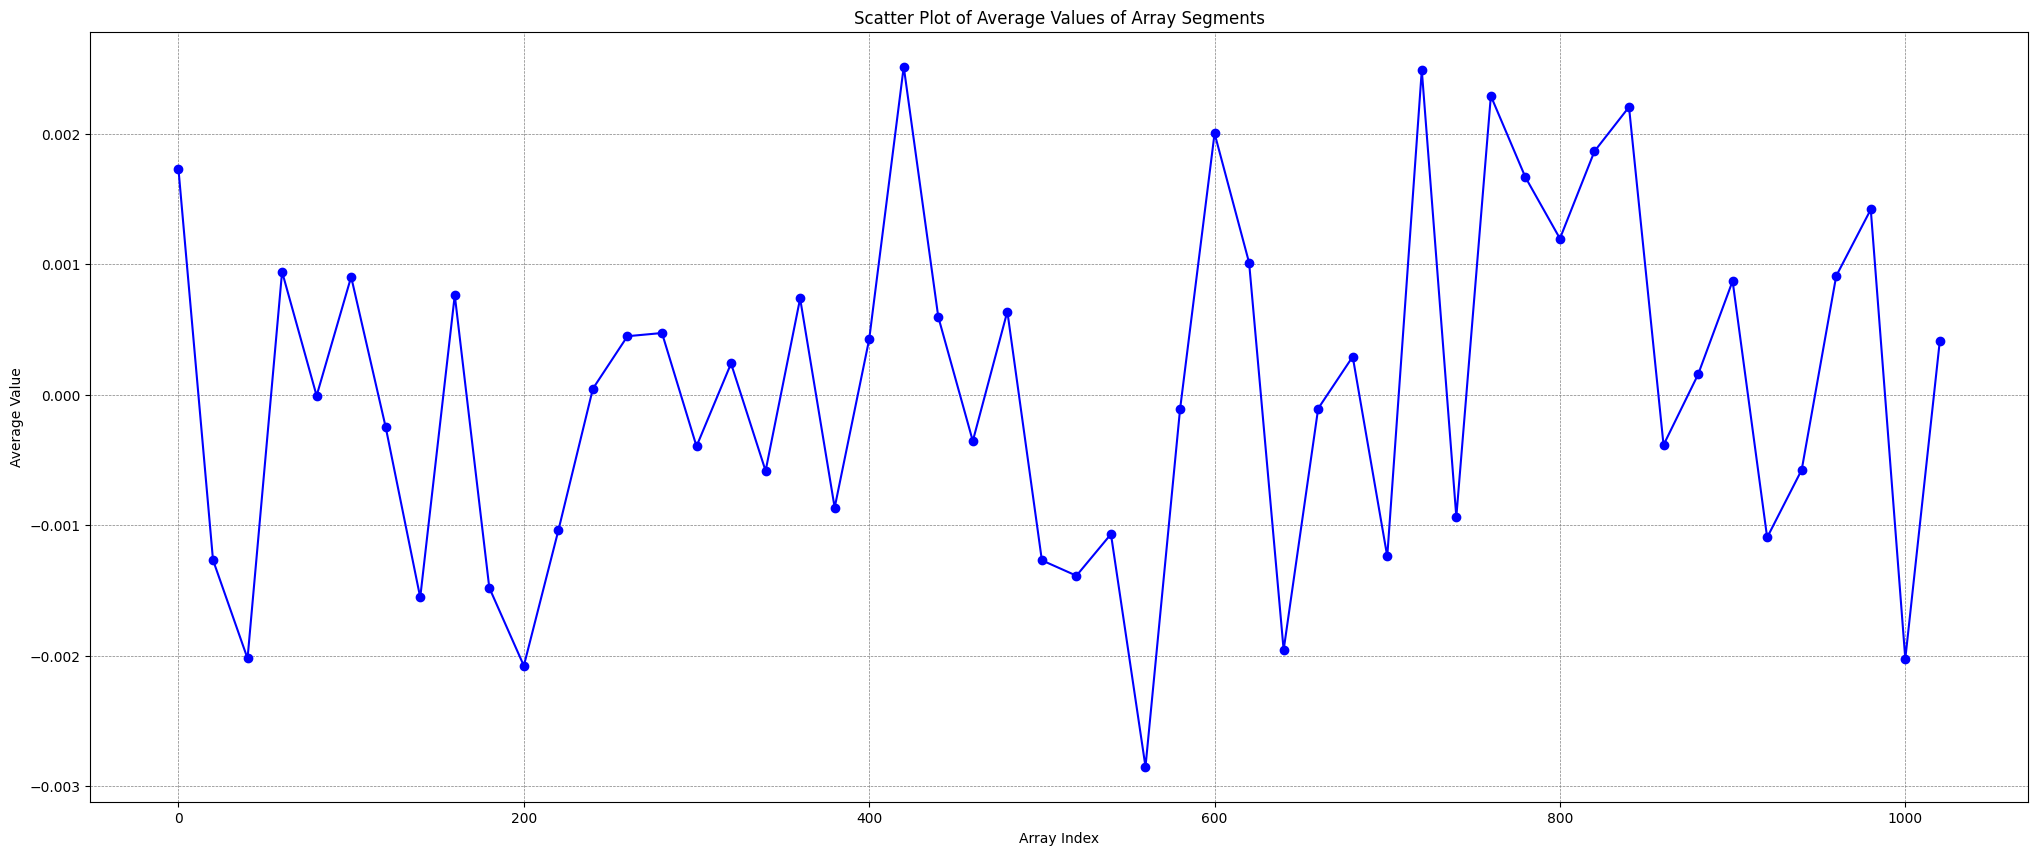

Calculating embeddings for 20 samples
Processing batch 0 to 1000
Time taken to encode: 0.21909809112548828
Time taken to encode: 0.031302452087402344


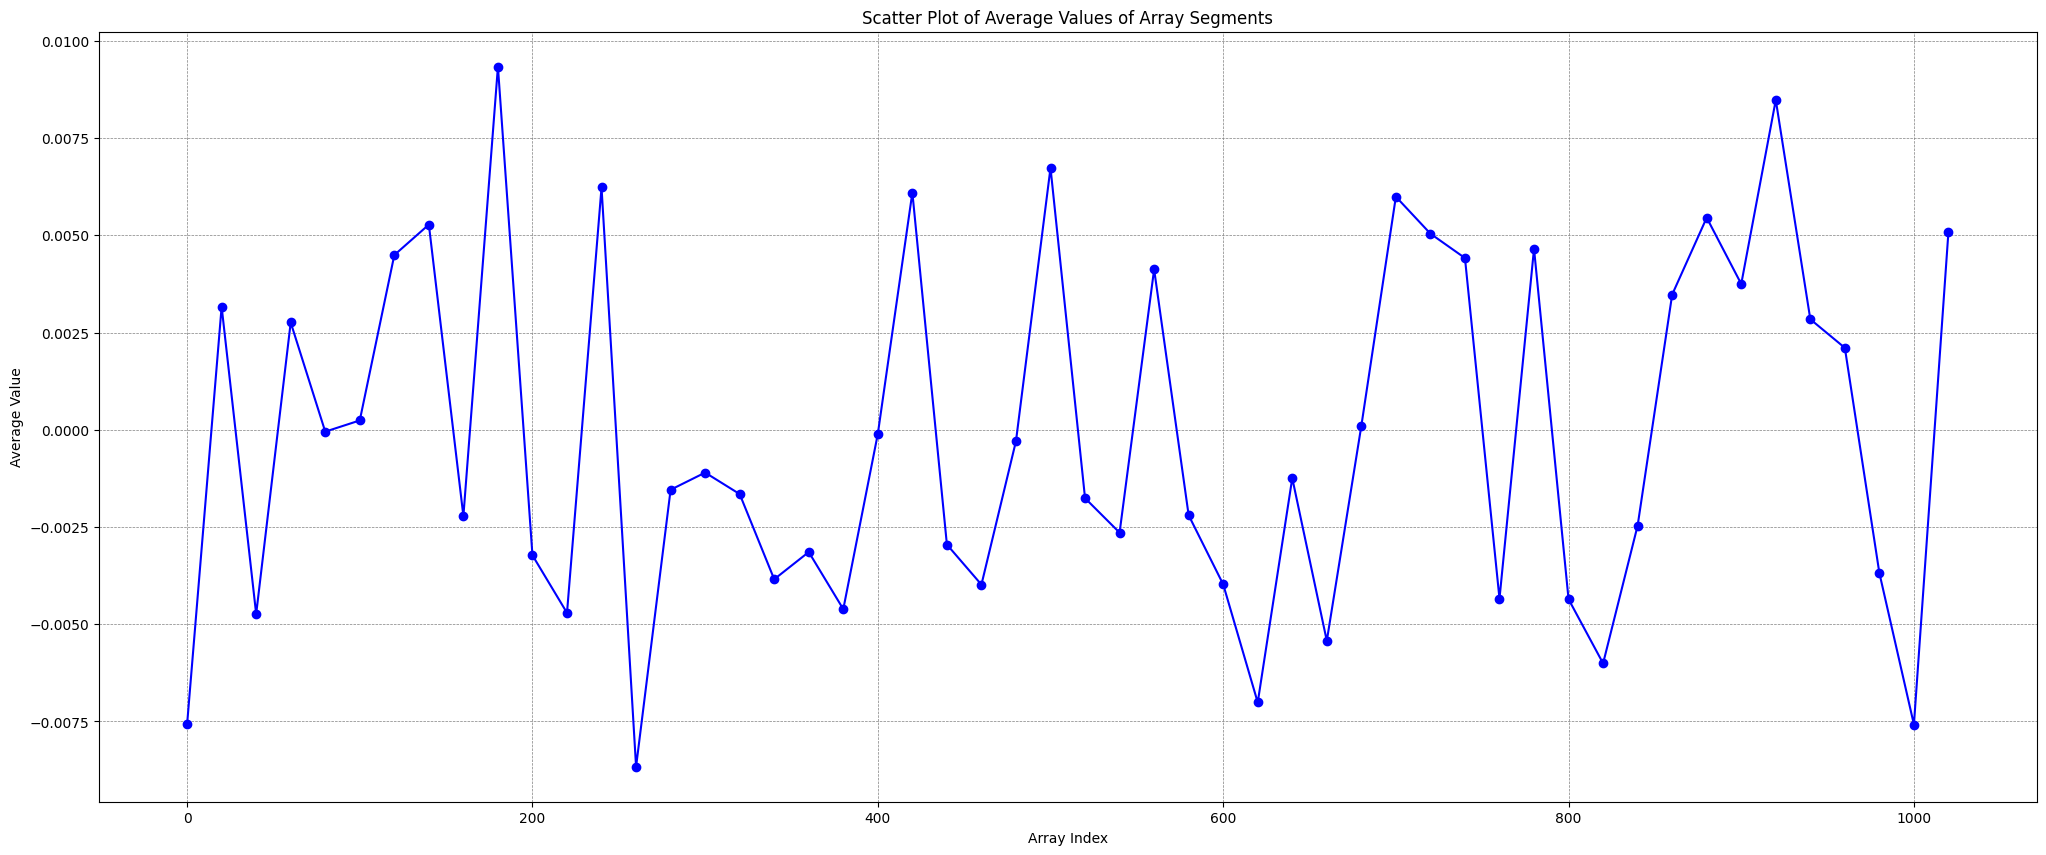

Calculating embeddings for 181 samples
Processing batch 0 to 1000
Time taken to encode: 0.06485152244567871
Time taken to encode: 1.5304596424102783


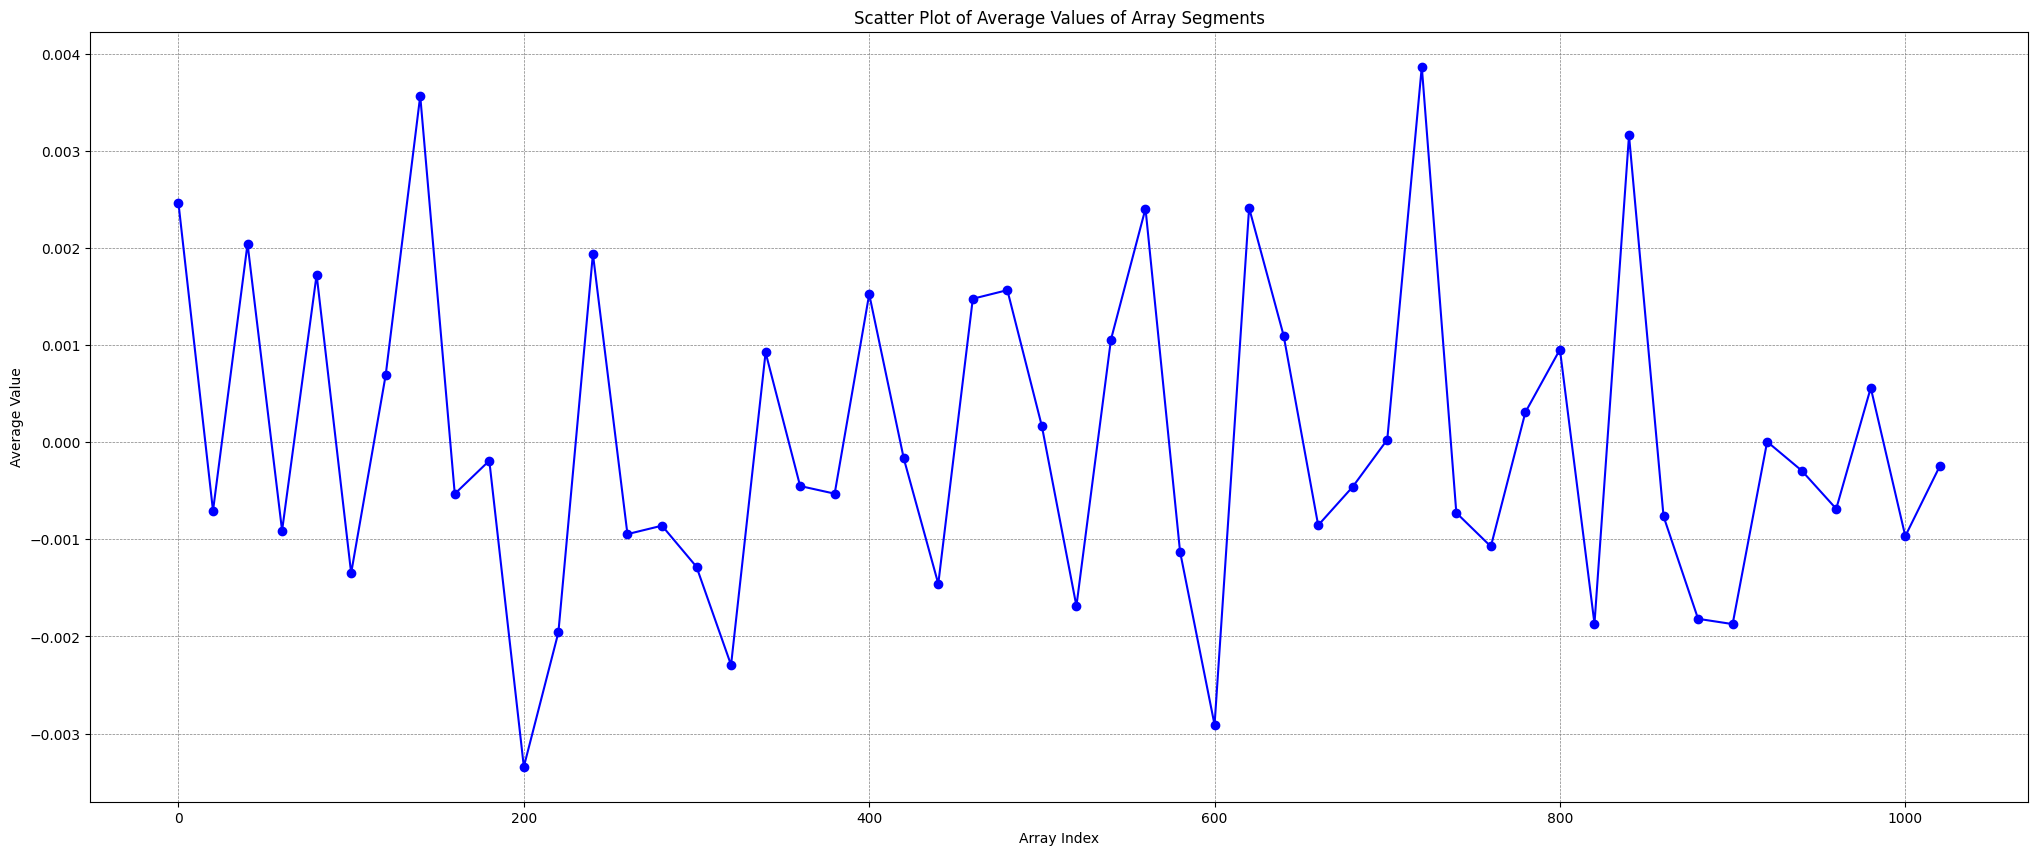

Calculating embeddings for 64 samples
Processing batch 0 to 1000
Time taken to encode: 0.034597158432006836
Time taken to encode: 0.5521600246429443


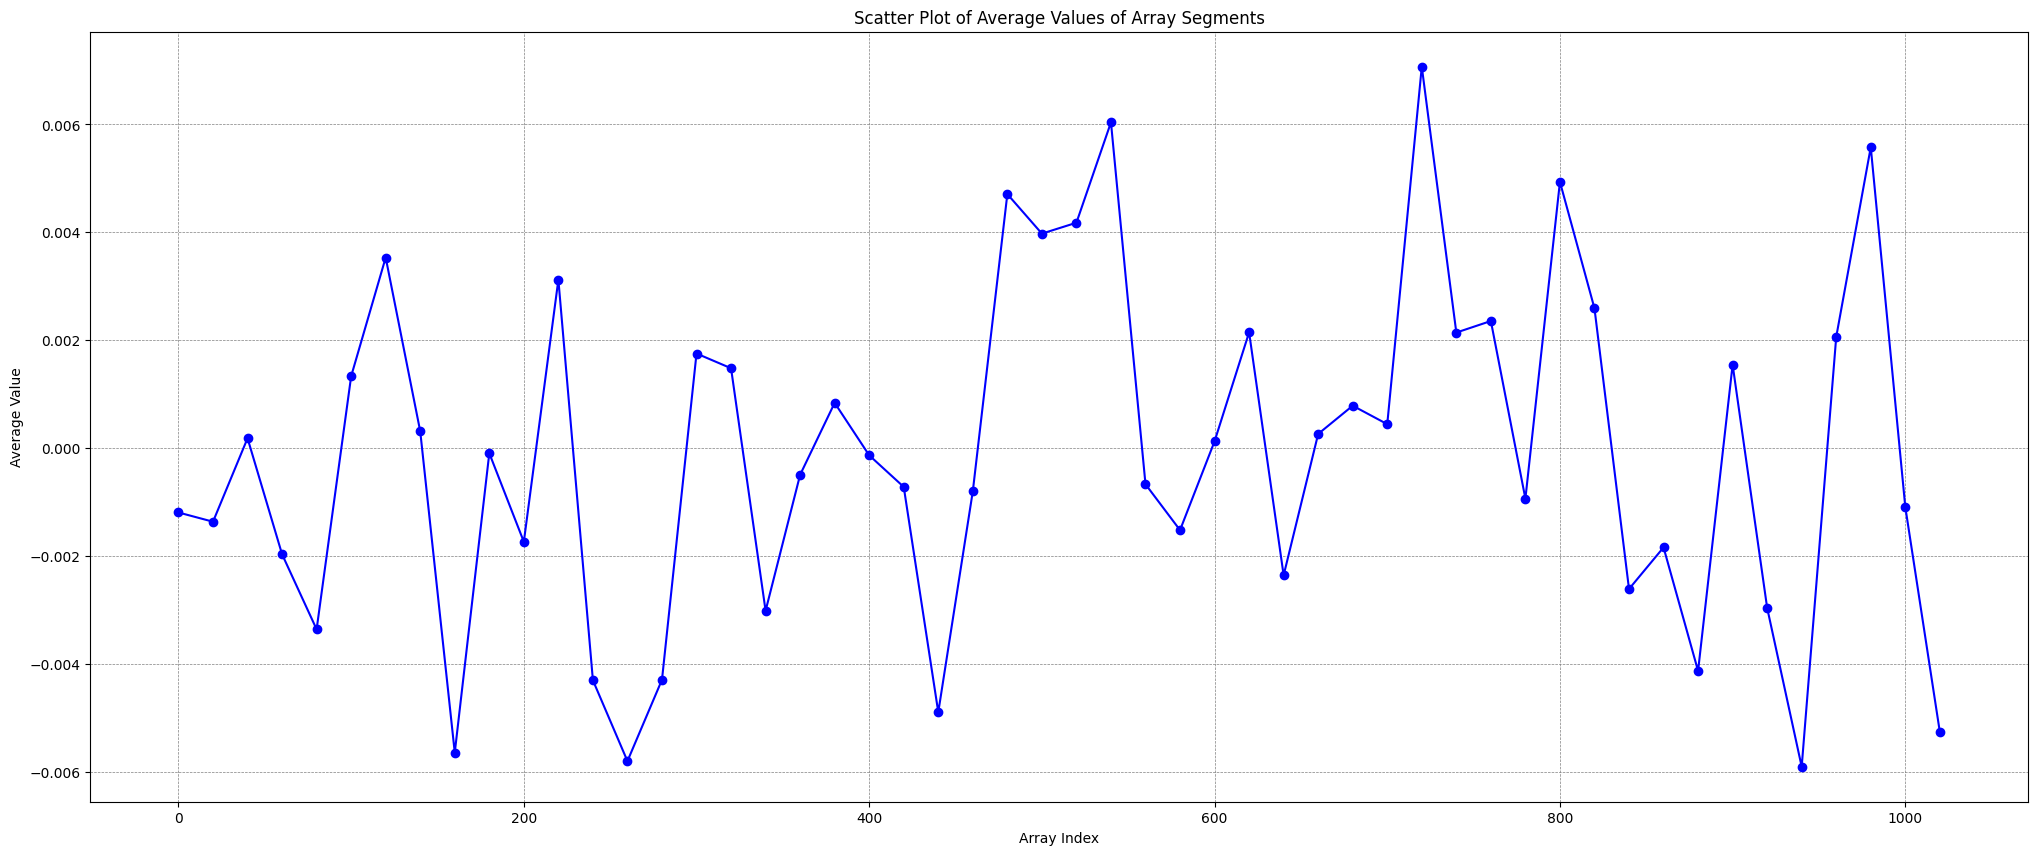

Calculating embeddings for 534 samples
Processing batch 0 to 1000
Time taken to encode: 0.10909748077392578


KeyboardInterrupt: 

In [4]:
embeddings_dict = {}
df = load_dataset("jpwahle/etpc")['train'].to_pandas()
single_type_dict = filter_for_single_pt(df)
bert_model_path = '/content/drive/MyDrive/Models/bert-large-uncased-jpwahle/checkpoint-3045/'
bert_model, bert_tokenizer = load_model(bert_model_path)

bert_model.to(mps_device)
bert_tokenizer
directory = '/content/drive/MyDrive/Models/bert-large-uncased-jpwahle/plots/'

for key, value in single_type_dict.items():
    embeddings = calculate_embeddings(value, bert_model, bert_tokenizer)
    result = embeddings[:, 1, :] - embeddings[:, 0, :]
    array_mean = np.mean(result, axis=0)
    safe_key = key.replace('/', '_').replace(' ', '_')
    plot_path = f'{directory}{safe_key}.png'
    plot_hist(array_mean, plot_path)

In [ ]:
embeddings_dict = {}
df = load_dataset("jpwahle/etpc")['train'].to_pandas()
single_type_dict = filter_for_single_pt(df)
bert_model_path = '/content/drive/MyDrive/Models/robert-large-uncased-jpwahle/checkpoint-1362'
bert_model, bert_tokenizer = load_model(bert_model_path)

bert_model.to(mps_device)
bert_tokenizer
directory = '/content/drive/MyDrive/Models/robert-large-uncased-jpwahle/plots/'

for key, value in single_type_dict.items():
    embeddings = calculate_embeddings(value, bert_model, bert_tokenizer)
    result = embeddings[:, 1, :] - embeddings[:, 0, :]
    array_mean = np.mean(result, axis=0)
    safe_key = key.replace('/', '_').replace(' ', '_')
    plot_path = f'{directory}{safe_key}.png'
    plot_hist(array_mean, plot_path)

In [34]:
748

embeddings_dict = {}
df = load_dataset("jpwahle/etpc")['train'].to_pandas()
single_type_dict = filter_for_single_pt(df)
bert_model_path = '/content/drive/MyDrive/Models/robert-large-uncased-jpwahle/checkpoint-1362'
bert_model, bert_tokenizer = load_model(bert_model_path)

Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/Models/robert-large-uncased-jpwahle/checkpoint-1362 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
length = -1
largest_data = ''
for key, value in single_type_dict.items():
  if len(value) > length:
    largest_data = key
    length = len(value)

In [15]:
embeddings_dict = {}
df = load_dataset("jpwahle/etpc")['train'].to_pandas()
single_type_dict = filter_for_single_pt(df)
bert_model_path = '/content/drive/MyDrive/Models/bert-large-uncased-jpwahle/checkpoint-3045/'
bert_model, bert_tokenizer = load_model(bert_model_path)


In [32]:
len(single_type_dict[largest_data])

3870

In [35]:
bert_model.to(mps_device)
directory = '/content/drive/MyDrive/Models/bert-large-uncased-jpwahle/plots/'

embeddings = calculate_embeddings(single_type_dict[largest_data], bert_model, bert_tokenizer)
result = embeddings[:, 1, :] - embeddings[:, 0, :]
corr_matrix = np.corrcoef(result, rowvar=False)

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - corr_matrix

Calculating embeddings for 3870 samples
Processing batch 0 to 1000
Time taken to encode: 0.514934778213501
Time taken to encode: 7.702211856842041
Processing batch 1000 to 2000
Time taken to encode: 0.22931146621704102
Time taken to encode: 8.170007705688477
Processing batch 2000 to 3000
Time taken to encode: 0.12793445587158203
Time taken to encode: 8.457434892654419
Processing batch 3000 to 4000
Time taken to encode: 0.09881258010864258
Time taken to encode: 7.769220590591431


<ipython-input-37-21b491191a90>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='weighted')


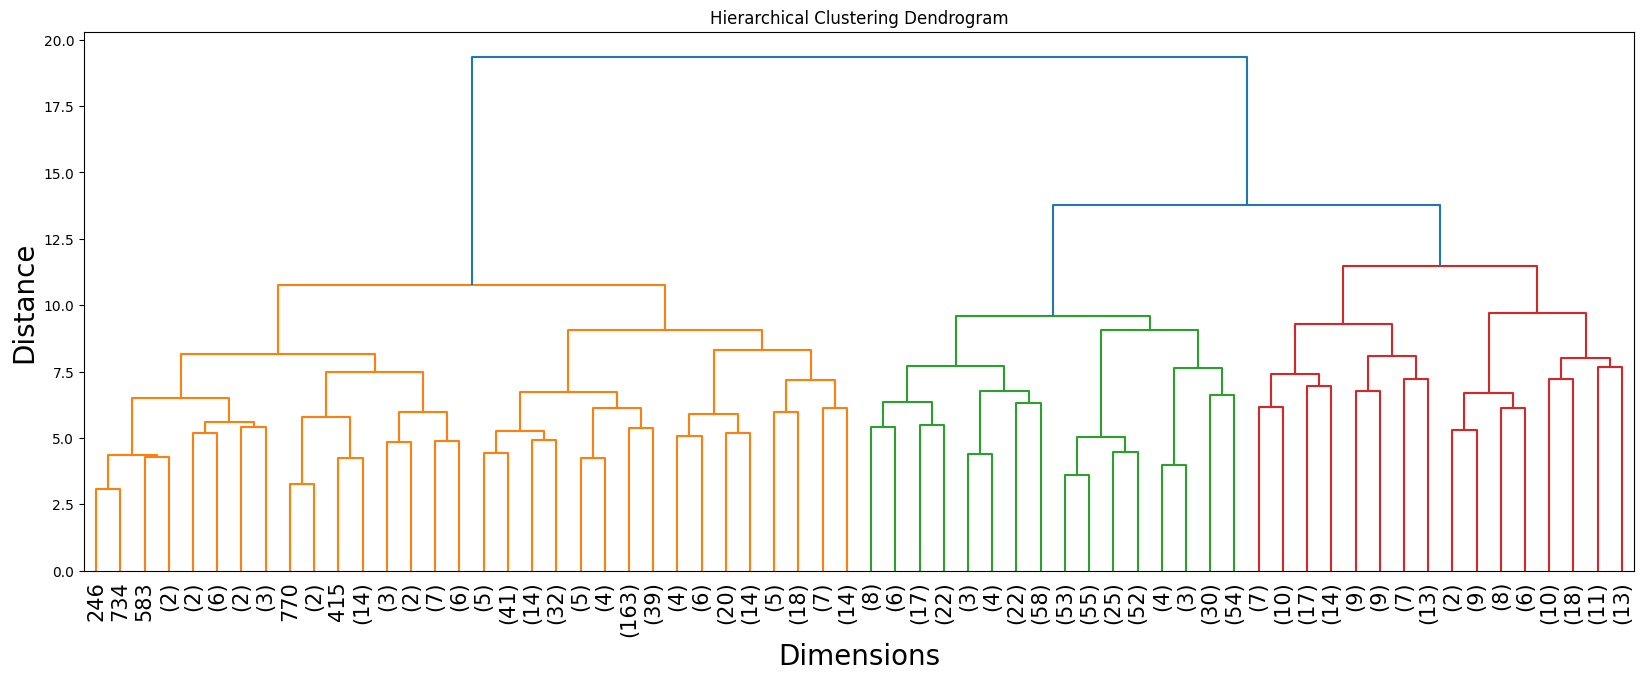

In [37]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Assuming distance_matrix and result are already defined
linked = sch.linkage(distance_matrix, method='weighted')

plt.figure(figsize=(20, 7))
dendrogram = sch.dendrogram(linked, labels=[f'{i+1}' for i in range(result.shape[1])], truncate_mode='level', p=5, leaf_font_size=15)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Dimensions', fontsize=20)  # Increase the font size for x-axis label
plt.ylabel('Distance', fontsize=20)    # Increase the font size for y-axis label
directory = '/content/drive/MyDrive/Models/bert-large-uncased-jpwahle/plots/'
# plt.savefig(f'{directory}-dendogram.png', dpi=1200)
plt.show()
